# 2. Run the dimensionality reduction methods!

In [12]:
import numpy as np
import os
PREFIX = os.path.join(os.environ["HOME"], "plink-182")
DATA_PREFIX = os.path.join(PREFIX, "data")
OUT_PREFIX = os.path.join(PREFIX, "dr_outputs")

# The number of PCs to generate for PCA and PCoA (rather than computing all of them, which
# is computationally expensive and not really necessary here). 20 is the default that plink uses:
# see https://www.cog-genomics.org/plink/1.9/strat#pca.
NUM_PCS = 20

## Define "method + hyperparameter combinations" to test

`method2hpsettings` is a dictionary that maps the dimensionality reduction method name (one of `"pca"`, `"pcoa"`, `"umap"`, or `"tsne"`) to a list of dictionaries defining the hyperparameter settings to try for that method. The total number of dictionaries within lists defines the number of different "method + hyperparameter combinations" to test.

In [15]:
method2hpsettings = {
    "pca": [{"whiten": False}, {"whiten": True}],
    "pcoa": [{"metric": "jaccard"}, {"metric": "braycurtis"}, {"metric": "canberra"}, {"metric": "manhattan"}],
    "umap": [{}],
    "tsne": [{}]
}

## Load genotype matrix
This is adapted from my PSET 2 part 1 solution.

In [9]:
genotypematrix = np.loadtxt(os.path.join(DATA_PREFIX, "chr_21_genotypes.tab")).T

## PCA
This is also adapted from my PSET 2 part 1 solution.

In [17]:
from sklearn.decomposition import PCA

for pca_hp_settings in method2hpsettings["pca"]:
    use_whitening = pca_hp_settings["whiten"]
    pca = PCA(whiten=use_whitening, n_components=NUM_PCS)
    sample_loadings = pca.fit_transform(genotypematrix)
    o_filename = os.path.join(OUT_PREFIX, "pca_sample_loadings_whiten{}.txt".format(use_whitening))
    np.savetxt(o_filename, sample_loadings)

KeyboardInterrupt: 

## PCoA

In [16]:
import skbio

for poca_hp_settings in method2hpsettings["pcoa"]:
    metric = poca_hp_settings["metric"]
    dist_matrix = skbio.diversity.beta_diversity(metric, genotypematrix)
    pcoa_results = skbio.stats.ordination.pcoa(dist_matrix, method="fsvd", number_of_dimensions=NUM_PCS)
    pcoa_results.samples.to_csv(
        os.path.join(OUT_PREFIX, "pcoa_sample_loadings_metric{}.txt".format(metric)),
        sep="\t",
        # Don't include header or row labels, to be consistent with the PCA output
        header=False,
        index=False
    )

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1575: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


## UMAP

In [ ]:
# Run UMAP
for poca_hp_settings in method2hpsettings["pcoa"]:
    pass

## t-SNE

In [ ]:
# Run t-SNE
for poca_hp_settings in method2hpsettings["pcoa"]:
    pass

## Visualize first two PCs for all methods

This code was mostly adapted from PS2, part 1. We streamlined the code a bit and added some logic to make the colors consistent for each of the five superpopulations present in 1000 Genomes.

In [50]:
%pylab inline
from matplotlib.ticker import StrMethodFormatter
    
####### Set up sample lists and color information -- this is just done once #####
# Load population labels
sample_to_pop = {}
with open("/datasets/cs284s-sp20-public/ps2/ps2_reference_labels.csv", "r") as f:
    for line in f:
        sample, pop = line.strip().split(",")
        sample_to_pop[sample] = pop

### Determine colors for each population group ###
# As is documented on https://piazza.com/class/k87p6hvsod51q6?cid=20, the original colors for
# this PSET were somewhat misleading. Here, we ensure that all populations within a superpopulation
# are colored identically.

# This was taken from https://www.internationalgenome.org/category/population/
pop_metadata = """CHB	Han Chinese in Beijing, China	EAS
JPT	Japanese in Tokyo, Japan	EAS
CHS	Southern Han Chinese	EAS
CDX	Chinese Dai in Xishuangbanna, China	EAS
KHV	Kinh in Ho Chi Minh City, Vietnam	EAS
CEU	Utah Residents (CEPH) with Northern and Western European Ancestry	EUR
TSI	Toscani in Italia	EUR
FIN	Finnish in Finland	EUR
GBR	British in England and Scotland	EUR
IBS	Iberian Population in Spain	EUR
YRI	Yoruba in Ibadan, Nigeria	AFR
LWK	Luhya in Webuye, Kenya	AFR
GWD	Gambian in Western Divisions in the Gambia	AFR
MSL	Mende in Sierra Leone	AFR
ESN	Esan in Nigeria	AFR
ASW	Americans of African Ancestry in SW USA	AFR
ACB	African Caribbeans in Barbados	AFR
MXL	Mexican Ancestry from Los Angeles USA	AMR
PUR	Puerto Ricans from Puerto Rico	AMR
CLM	Colombians from Medellin, Colombia	AMR
PEL	Peruvians from Lima, Peru	AMR
GIH	Gujarati Indian from Houston, Texas	SAS
PJL	Punjabi from Lahore, Pakistan	SAS
BEB	Bengali from Bangladesh	SAS
STU	Sri Lankan Tamil from the UK	SAS
ITU	Indian Telugu from the UK	SAS"""

# These are *roughly* the same colors as were used for this PSET (i.e. AFR samples are red, EAS samples
# are green, EUR samples are yellow, SAS samples are orange)
superpop_to_color = {
    "AFR": "red", "EAS": "green", "EUR": "yellow", "SAS": "orange", "AMR": "blue", "None": "gray"
}
pop_to_superpop = {"None": "None"}
for line in pop_metadata.split("\n"):
    split_line = line.strip().split("\t")
    pop_to_superpop[split_line[0]] = split_line[2]

# Load samples list and get populations, then superpopulations, then colors
samples = [item.strip() for item in open(os.path.join(DATA_PREFIX, "sample_ids.txt"), "r").readlines()]
colors = []
for sample in samples:
    pop = sample_to_pop.get(sample, "None")
    color = superpop_to_color[pop_to_superpop[pop]]
    colors.append(color)

def visualize_sample_loadings(sample_loadings_filepath, dr_type, hp_names):
    sample_loadings = np.loadtxt(sample_loadings_filepath)
    pc1 = sample_loadings[:, 0]
    pc2 = sample_loadings[:, 1]

    # Figure out what hyperparameters were set in the creation of these results
    # This is done by inspecting the filename, and is pretty hacky
    hp_desc = ""
    for hp in hp_names:
        hp_info = sample_loadings_filepath.split(hp)[1]
        hp_value = hp_info.split("/")[-1].split(".")[0].split("_")[0]
        hp_desc += "{}: {}".format(hp, hp_value)
    
    # Make the plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(pc1, pc2, color=colors, s=5)
    
    # Set titles and labels
    ax.set_title("{}\n{}".format(dr_type, hp_desc))
    ax.set_xlabel("PC 1", size=15)
    ax.set_ylabel("PC 2", size=15)
    
    # Other minor formatting tweaks (all taken from PSET 2 as mentioned above, I'm not
    # familiar enough with matplotlib's API to know how to do this ;)
    ax.set_xticklabels(ax.get_xticks(), size=12)
    ax.set_yticklabels(ax.get_yticks(), size=12)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
    # Quick hack to limit each label to two digits' worth of precision. I tried
    # doing this using matplotlib's API more elegantly (e.g. StrMethodFormatter)
    # and that didn't work, hence this solution (taken from this Stack Overflow
    # comment: https://stackoverflow.com/a/50045907/10730311)
    
    # First, get string representations of the x-axis labels
    labels = [item.get_text() for item in ax.get_xticklabels()]
    # To quote that SO post :), "Beat them into submission and set them back again"
    ax.set_xticklabels([str(round(float(label), 2)) for label in labels])
    
    # Repeat above with the y-axis labels
    labels = [item.get_text() for item in ax.get_yticklabels()]
    ax.set_yticklabels([str(round(float(label), 2)) for label in labels])

Populating the interactive namespace from numpy and matplotlib


### Visualize PCA

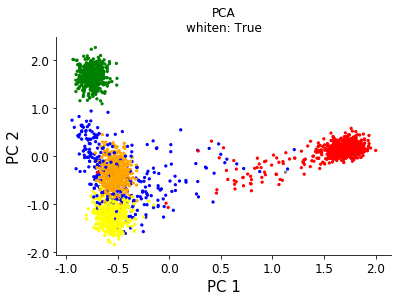

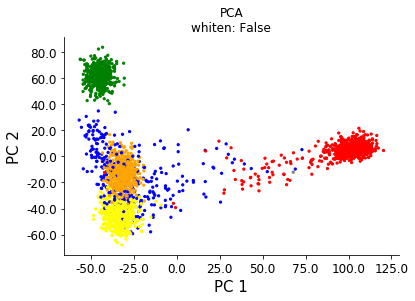

In [51]:
for fn in os.listdir(OUT_PREFIX):
    if fn.startswith("pca"):
        visualize_sample_loadings(os.path.join(OUT_PREFIX, fn), "PCA", ["whiten"])

### Visualize PCoA

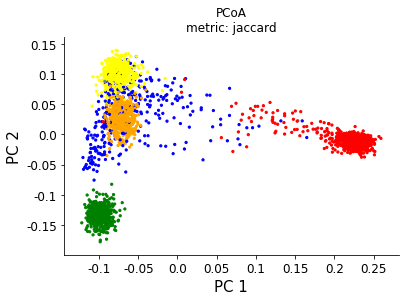

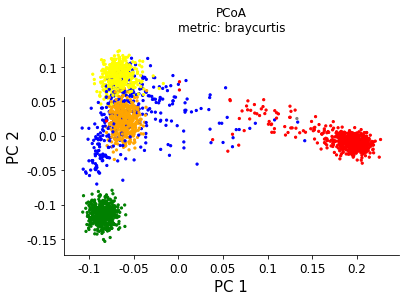

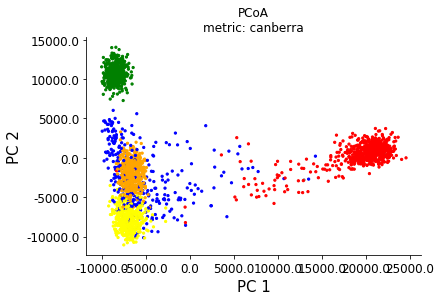

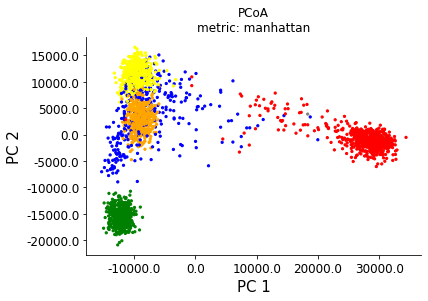

In [52]:
for fn in os.listdir(OUT_PREFIX):
    if fn.startswith("pcoa"):
        visualize_sample_loadings(os.path.join(OUT_PREFIX, fn), "PCoA", ["metric"])